# Import and Clean Data

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from collections import defaultdict
from copy import deepcopy
from sklearn.linear_model import LogisticRegression

#import data
df = pd.read_csv('compas-scores-two-years.csv')
df = df.sample(frac = 1)

#Select only African American and Caucasian line items
data = df[(df['race']=='African-American')|(df['race']=='Caucasian')]

#Clean Up/Trim Data values
data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
data['stay_length'] = (pd.to_datetime(data.c_jail_out) - pd.to_datetime(data.c_jail_in)).astype('timedelta64[D]')
data = data.dropna(subset=['stay_length'])
data = data[data.is_recid != -1]
data = data[data.c_charge_degree != "O"]
data = data[data.score_text != "N/A"]
data = data.drop(['first','last','compas_screening_date','c_case_number','violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
          'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
          'r_offense_date','r_case_number','r_charge_degree','dob','name','v_type_of_assessment','type_of_assessment'], axis=1)

#any missing values in the c_days_from_compas column are replaced with the mode value of that column, effectively filling in the missing values with the most frequently occurring value.
data['c_days_from_compas'] = data['c_days_from_compas'].fillna(data['c_days_from_compas'].mode()[0])
data=data.dropna()

#Define X and Y datasets
x = data.set_index(data.id)
x = x.drop(['id'],axis=1)
x = x.drop(['c_jail_out','c_jail_in','c_offense_date','c_charge_desc','out_custody','in_custody','screening_date','v_screening_date'],axis=1)

y = data[['two_year_recid']]
y = y.set_index(data.id)

#Convert variables into numerics
x['race']= x['race'].replace(['Caucasian','African-American',],[1,0])
x['sex'] = x['sex'].replace(['Female','Male'],[1,0])
x['c_charge_degree'] = x['c_charge_degree'].replace(['F','M'],[1,0])
x['age_cat'] = x['age_cat'].replace(['25 - 45','Less than 25', 'Greater than 45'],[0,1,2])
x['score_text'] = x['score_text'].replace(['Low', 'High', 'Medium'],[0,1,2])
x['v_score_text'] = x['v_score_text'].replace(['Low', 'High', 'Medium'],[0,1,2])
x = x.fillna(0)
#Prepare Data for Training 

#Convert the target variable into Numpy array
y=np.array(y)

#Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.1,random_state=44)


x_train = x_train.loc[:, x_train.columns != 'race']
x_test = x_test.loc[:, x_test.columns != 'race']

#Reset index of training/testing variables
x_train=x_train.reset_index()
x_test=x_test.reset_index()

#Drop ID column
x_train = x_train.drop(['id'], axis=1)
x_test = x_test.drop(['id'], axis=1)


# Optimize Fairness Accuracy Constraints- Function Definitions

Source: GitHub (https://github.com/mbilalzafar/fair-classification/blob/master/disparate_impact/adult_data_demo/demo_constraints.py) associated with paper (https://arxiv.org/abs/1507.05259)

The GitHub associated with the data provides the following functions to run this method of optimization. We made small tweaks as necessary for our dataset.

In [8]:
def compute_p_rule(x_control, class_labels):

    """ Compute the p-rule based on Doctrine of disparate impact """

    non_prot_all = sum(x_control == 1.0) # non-protected group
    prot_all = sum(x_control == 0.0) # protected group
    non_prot_pos = sum(class_labels[x_control == 1.0] == 1.0) # non_protected in positive class
    prot_pos = sum(class_labels[x_control == 0.0] == 1.0) # protected in positive class
    frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
    frac_prot_pos = float(prot_pos) / float(prot_all)
    p_rule = (frac_prot_pos / frac_non_prot_pos) * 100.0
    print()
    print("Total data points: %d" % (len(x_control)))
    print("# non-protected examples: %d" % (non_prot_all))
    print("# protected examples: %d" % (prot_all))
    print("Non-protected in positive class: %d (%0.0f%%)" % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all))
    print("Protected in positive class: %d (%0.0f%%)" % (prot_pos, prot_pos * 100.0 / prot_all))
    print("P-rule is: %0.0f%%" % ( p_rule ))
    return p_rule

def add_intercept(x):

    """ Add intercept to the data before linear classification """
    m,n = x.shape
    intercept = np.ones(m).reshape(m, 1) # the constant b
    return np.concatenate((intercept, x), axis = 1)

def split_into_train_test(x_all, y_all, x_control_all, train_fold_size):

    split_point = int(round(float(x_all.shape[0]) * train_fold_size))
    x_all_train = x_all[:split_point]
    x_all_test = x_all[split_point:]
    y_all_train = y_all[:split_point]
    y_all_test = y_all[split_point:]
    x_control_all_train = {}
    x_control_all_test = {}
    for k in x_control_all.keys():
        x_control_all_train[k] = x_control_all[k][:split_point]
        x_control_all_test[k] = x_control_all[k][split_point:]

    return x_all_train, y_all_train, x_control_all_train, x_all_test, y_all_test, x_control_all_test

def train_model(x, y, x_control, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma=None):

    """
    Function that trains the model subject to various fairness constraints.
    If no constraints are given, then simply trains an unaltered classifier.
    Example usage in: "synthetic_data_demo/decision_boundary_demo.py"
    ----
    Inputs:
    X: (n) x (d+1) numpy array -- n = number of examples, d = number of features, one feature is the intercept
    y: 1-d numpy array (n entries)
    x_control: dictionary of the type {"s": [...]}, key "s" is the sensitive feature name, and the value is a 1-d list with n elements holding the sensitive feature values
    loss_function: the loss function that we want to optimize -- for now we have implementation of logistic loss, but other functions like hinge loss can also be added
    apply_fairness_constraints: optimize accuracy subject to fairness constraint (0/1 values)
    apply_accuracy_constraint: optimize fairness subject to accuracy constraint (0/1 values)
    sep_constraint: apply the fine grained accuracy constraint
        for details, see Section 3.3 of arxiv.org/abs/1507.05259v3
        For examples on how to apply these constraints, see "synthetic_data_demo/decision_boundary_demo.py"
    Note: both apply_fairness_constraints and apply_accuracy_constraint cannot be 1 at the same time
    sensitive_attrs: ["s1", "s2", ...], list of sensitive features for which to apply fairness constraint, all of these sensitive features should have a corresponding array in x_control
    sensitive_attrs_to_cov_thresh: the covariance threshold that the classifier should achieve (this is only needed when apply_fairness_constraints=1, not needed for the other two constraints)
    gamma: controls the loss in accuracy we are willing to incur when using apply_accuracy_constraint and sep_constraint
    ----
    Outputs:
    w: the learned weight vector for the classifier
    """


    assert((apply_accuracy_constraint == 1 and apply_fairness_constraints == 1) == False) # both constraints cannot be applied at the same time

    max_iter = 100000 # maximum number of iterations for the minimization algorithm

    if apply_fairness_constraints == 0:
        constraints = []
    else:
        constraints = get_constraint_list_cov(x, y, x_control, sensitive_attrs, sensitive_attrs_to_cov_thresh)      

    if apply_accuracy_constraint == 0: #its not the reverse problem, just train w with cross cov constraints

        f_args=(x, y)
        w = minimize(fun = loss_function,
            x0 = np.random.rand(x.shape[1],),
            args = f_args,
            method = 'SLSQP',
            options = {"maxiter":max_iter},
            constraints = constraints
            )

    else:

        # train on just the loss function
        w = minimize(fun = loss_function,
            x0 = np.random.rand(x.shape[1],),
            args = (x, y),
            method = 'SLSQP',
            options = {"maxiter":max_iter},
            constraints = []
            )

        old_w = deepcopy(w.x)
        

        def constraint_gamma_all(w, x, y,  initial_loss_arr):
            
            gamma_arr = np.ones_like(y) * gamma # set gamma for everyone
            new_loss = loss_function(w, x, y)
            old_loss = sum(initial_loss_arr)
            return ((1.0 + gamma) * old_loss) - new_loss

        def constraint_protected_people(w,x,y): # dont confuse the protected here with the sensitive feature protected/non-protected values -- protected here means that these points should not be misclassified to negative class
            return np.dot(w, x.T) # if this is positive, the constraint is satisfied
        def constraint_unprotected_people(w,ind,old_loss,x,y):
            
            new_loss = loss_function(w, np.array([x]), np.array(y))
            return ((1.0 + gamma) * old_loss) - new_loss

        constraints = []
        predicted_labels = np.sign(np.dot(w.x, x.T))
        unconstrained_loss_arr = loss_function(w.x, x, y, return_arr=True)

        if sep_constraint == True: # separate gemma for different people
            for i in range(0, len(predicted_labels)):
                if predicted_labels[i] == 1.0 and x_control[sensitive_attrs[0]][i] == 1.0: # for now we are assuming just one sensitive attr for reverse constraint, later, extend the code to take into account multiple sensitive attrs
                    c = ({'type': 'ineq', 'fun': constraint_protected_people, 'args':(x[i], y[i])}) # this constraint makes sure that these people stay in the positive class even in the modified classifier             
                    constraints.append(c)
                else:
                    c = ({'type': 'ineq', 'fun': constraint_unprotected_people, 'args':(i, unconstrained_loss_arr[i], x[i], y[i])})                
                    constraints.append(c)
        else: # same gamma for everyone
            c = ({'type': 'ineq', 'fun': constraint_gamma_all, 'args':(x,y,unconstrained_loss_arr)})
            constraints.append(c)

        def cross_cov_abs_optm_func(weight_vec, x_in, x_control_in_arr):
            cross_cov = (x_control_in_arr - np.mean(x_control_in_arr)) * np.dot(weight_vec, x_in.T)
            return float(abs(sum(cross_cov))) / float(x_in.shape[0])


        w = minimize(fun = cross_cov_abs_optm_func,
            x0 = old_w,
            args = (x, x_control[sensitive_attrs[0]]),
            method = 'SLSQP',
            options = {"maxiter":100000},
            constraints = constraints
            )

    try:
        assert(w.success == True)
    except:
        print("Optimization problem did not converge.. Check the solution returned by the optimizer.")
        print("Returned solution is:")
        print(w)



    return w.x

def check_accuracy(model, x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):


    """
    returns the train/test accuracy of the model
    we either pass the model (w)
    else we pass y_predicted
    """
    if model is not None and y_test_predicted is not None:
        print("Either the model (w) or the predicted labels should be None")
        raise Exception("Either the model (w) or the predicted labels should be None")

    if model is not None:
        y_test_predicted = np.sign(np.dot(x_test, model))
        y_train_predicted = np.sign(np.dot(x_train, model))

    def get_accuracy(y, Y_predicted):
        correct_answers = (Y_predicted == y).astype(int) # will have 1 when the prediction and the actual label match
        accuracy = float(sum(correct_answers)) / float(len(correct_answers))
        return accuracy, sum(correct_answers)

    train_score, correct_answers_train = get_accuracy(y_train, y_train_predicted)
    test_score, correct_answers_test = get_accuracy(y_test, y_test_predicted)

    return train_score, test_score, correct_answers_train, correct_answers_test
        
def get_correlations(model, x_test, y_predicted, x_control_test, sensitive_attrs):
    

    """
    returns the fraction in positive class for sensitive feature values
    """

    if model is not None:
        y_predicted = np.sign(np.dot(x_test, model))
        
    y_predicted = np.array(y_predicted)
    
    out_dict = {}
    for attr in sensitive_attrs:

        attr_val = []
        for v in x_control_test[attr]: attr_val.append(v)
        assert(len(attr_val) == len(y_predicted))


        total_per_val = defaultdict(int)
        attr_to_class_labels_dict = defaultdict(lambda: defaultdict(int))

        for i in range(0, len(y_predicted)):
            val = attr_val[i]
            label = y_predicted[i]

            # val = attr_val_int_mapping_dict_reversed[val] # change values from intgers to actual names
            total_per_val[val] += 1
            attr_to_class_labels_dict[val][label] += 1

        class_labels = set(y_predicted.tolist())

        local_dict_1 = {}
        for k1,v1 in attr_to_class_labels_dict.items():
            total_this_val = total_per_val[k1]

            local_dict_2 = {}
            for k2 in class_labels: # the order should be the same for printing
                v2 = v1[k2]

                f = float(v2) * 100.0 / float(total_this_val)


                local_dict_2[k2] = f
            local_dict_1[k1] = local_dict_2
        out_dict[attr] = local_dict_1

    return out_dict

def print_covariance_sensitive_attrs(model, x_arr, y_arr_dist_boundary, x_control, sensitive_attrs):


    """
    returns the covariance between sensitive features and distance from decision boundary
    """

    arr = []
    if model is None:
        arr = y_arr_dist_boundary # simplt the output labels
    else:
        arr = np.dot(model, x_arr.T) # the product with the weight vector -- the sign of this is the output label
    

    sensitive_attrs_to_cov_original = {}
    for attr in sensitive_attrs:

        attr_arr = x_control[attr]


        bin_attr = check_binary(attr_arr) # check if the attribute is binary (0/1), or has more than 2 vals
        if bin_attr == False: # if its a non-binary sensitive feature, then perform one-hot-encoding
            attr_arr_transformed, index_dict = get_one_hot_encoding(attr_arr)

        thresh = 0

        if bin_attr:
            cov = thresh - test_sensitive_attr_constraint_cov(None, x_arr, arr, np.array(attr_arr), thresh, False)
            sensitive_attrs_to_cov_original[attr] = cov
        else: # sensitive feature has more than 2 categorical values            
            
            cov_arr = []
            sensitive_attrs_to_cov_original[attr] = {}
            for attr_val, ind in index_dict.items():
                t = attr_arr_transformed[:,ind]
                cov = thresh - test_sensitive_attr_constraint_cov(None, x_arr, arr, t, thresh, False)
                sensitive_attrs_to_cov_original[attr][attr_val] = cov
                cov_arr.append(abs(cov))

            cov = max(cov_arr)
            
    return sensitive_attrs_to_cov_original

def print_classifier_fairness_stats(acc_arr, correlation_dict_arr, cov_dict_arr, s_attr_name):
    
    correlation_dict = get_avg_correlation_dict(correlation_dict_arr)
    non_prot_pos = correlation_dict[s_attr_name][1][1]
    prot_pos = correlation_dict[s_attr_name][0][1]
    p_rule = (prot_pos / non_prot_pos) * 100.0
    
    print("Accuracy: %0.2f" % (np.mean(acc_arr)))
    print("Protected/non-protected in +ve class: %0.0f%% / %0.0f%%" % (prot_pos, non_prot_pos))
    print("P-rule achieved: %0.0f%%" % (p_rule))
    print("Covariance between sensitive feature and decision from distance boundary : %0.3f" % (np.mean([v[s_attr_name] for v in cov_dict_arr])))
    print()
    return p_rule

def _logistic_loss(w, X, y, return_arr=None):
    """Computes the logistic loss.
    This function is used from scikit-learn source code
    Parameters
    ----------
    w : ndarray, shape (n_features,) or (n_features + 1,)
        Coefficient vector.
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data.
    y : ndarray, shape (n_samples,)
        Array of labels.
    """


    yz = y * np.dot(X,w)
    # Logistic loss is the negative of the log of the logistic function.
    if return_arr == True:
        out = -(log_logistic(yz))
    else:
        out = -np.sum(log_logistic(yz))
    return out

def log_logistic(X):

    """ This function is used from scikit-learn source code. Source link below """

    """Compute the log of the logistic function, ``log(1 / (1 + e ** -x))``.
    This implementation is numerically stable because it splits positive and
    negative values::
        -log(1 + exp(-x_i))     if x_i > 0
        x_i - log(1 + exp(x_i)) if x_i <= 0
    Parameters
    ----------
    X: array-like, shape (M, N)
        Argument to the logistic function
    Returns
    -------
    out: array, shape (M, N)
        Log of the logistic function evaluated at every point in x
    Notes
    -----
    Source code at:
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py
    -----
    See the blog post describing this implementation:
    http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/
    """
    if X.ndim > 1: raise Exception("Array of samples cannot be more than 1-D!")
    out = np.empty_like(X) # same dimensions and data types

    idx = X>0
    out[idx] = -np.log(1.0 + np.exp(-X[idx]))
    out[~idx] = X[~idx] - np.log(1.0 + np.exp(X[~idx]))
    return out

def check_binary(arr):
    "give an array of values, see if the values are only 0 and 1"
    s = sorted(set(arr))
    if s[0] == 0 and s[1] == 1:
        return True
    else:
        return False
    
def test_sensitive_attr_constraint_cov(model, x_arr, y_arr_dist_boundary, x_control, thresh, verbose):

    
    """
    The covariance is computed b/w the sensitive attr val and the distance from the boundary
    If the model is None, we assume that the y_arr_dist_boundary contains the distace from the decision boundary
    If the model is not None, we just compute a dot product or model and x_arr
    for the case of SVM, we pass the distace from bounday becase the intercept in internalized for the class
    and we have compute the distance using the project function
    this function will return -1 if the constraint specified by thresh parameter is not satifsified
    otherwise it will reutrn +1
    if the return value is >=0, then the constraint is satisfied
    """

    


    assert(x_arr.shape[0] == x_control.shape[0])
    if len(x_control.shape) > 1: # make sure we just have one column in the array
        assert(x_control.shape[1] == 1)
    
    arr = []
    if model is None:
        arr = y_arr_dist_boundary # simply the output labels
    else:
        arr = np.dot(model, x_arr.T) # the product with the weight vector -- the sign of this is the output label
    
    arr = np.array(arr, dtype=np.float64)


    cov = np.dot(x_control - np.mean(x_control), arr ) / float(len(x_control))

        
    ans = thresh - abs(cov) # will be <0 if the covariance is greater than thresh -- that is, the condition is not satisfied
    # ans = thresh - cov # will be <0 if the covariance is greater than thresh -- that is, the condition is not satisfied
    if verbose is True:
        print("Covariance is", cov)
        print("Diff is:", ans)
        print
    return ans

def get_avg_correlation_dict(correlation_dict_arr):
    # make the structure for the correlation dict
    correlation_dict_avg = {}
    # print correlation_dict_arr
    for k,v in correlation_dict_arr[0].items():
        correlation_dict_avg[k] = {}
        for feature_val, feature_dict in v.items():
            correlation_dict_avg[k][feature_val] = {}
            for class_label, frac_class in feature_dict.items():
                correlation_dict_avg[k][feature_val][class_label] = []

    # populate the correlation dict
    for correlation_dict in correlation_dict_arr:
        for k,v in correlation_dict.items():
            for feature_val, feature_dict in v.items():
                for class_label, frac_class in feature_dict.items():
                    correlation_dict_avg[k][feature_val][class_label].append(frac_class)

    # now take the averages
    for k,v in correlation_dict_avg.items():
        for feature_val, feature_dict in v.items():
            for class_label, frac_class_arr in feature_dict.items():
                correlation_dict_avg[k][feature_val][class_label] = np.mean(frac_class_arr)

    return correlation_dict_avg

# Baseline Model

In [9]:
base_model = LogisticRegression().fit(x_train, y_train)

/Users/xuefei/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xuefei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
accuracy_train_compas = base_model.score(x_train, y_train)

In [12]:
print("Scores for Train:")
print("Accuracy: ", accuracy_train_compas)

Scores for Train:
Accuracy:  0.9907878787878788


# Optimize Fairness Accuracy Constraints- Testing on COMPAS Data

Source: GitHub (https://github.com/mbilalzafar/fair-classification/blob/master/disparate_impact/adult_data_demo/demo_constraints.py) associated with paper (https://arxiv.org/abs/1507.05259)

We adapted the code provided for a demo on another data set.

In [15]:
def test_compas_data(X,y,x_control):

    """ Load the compas data """

    compute_p_rule(x_control["race"], y) # compute the p-rule in the original data

    """ Split the data into train and test """
    X = add_intercept(X) # add intercept to X before applying the linear classifier
    train_fold_size = 0.7
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = split_into_train_test(X, y, x_control, train_fold_size)
    
    apply_fairness_constraints = None
    apply_accuracy_constraint = None
    sep_constraint = None

    loss_function = _logistic_loss
    sensitive_attrs = ["race"]
    sensitive_attrs_to_cov_thresh = {}
    gamma = None

    """ Classify such that we optimize for fairness subject to a certain loss in accuracy """
    print()
    print("== Classifier with accuracy constraint ==")
    apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
    apply_accuracy_constraint = 1 # now, we want to optimize fairness subject to accuracy constraints
    sep_constraint = 0
    gamma = .5 # gamma controls how much loss in accuracy we are willing to incur to achieve fairness -- increase gamme to allow more loss in accuracy
    
    w = train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    p_rule = print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0]) 
    w_a_cons = w
    p_a_cons = p_rule
    acc_a_cons = test_score
    
    """ Classify such that we optimize for fairness subject to a certain loss in accuracy WITH FINE GRAIN"""
    print()
    print("== Classifier with accuracy constraint (FINE GRAIN)==")
    apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
    apply_accuracy_constraint = 1 # now, we want to optimize fairness subject to accuracy constraints
    sep_constraint = .1
    gamma = .5 # gamma controls how much loss in accuracy we are willing to incur to achieve fairness -- increase gamme to allow more loss in accuracy
    
    w = train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    p_rule = print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0]) 
    w_a_cons = w
    p_a_cons = p_rule
    acc_a_cons = test_score
    
    return

X = np.array(x.drop(columns = ['race']))
y = np.array(y).flatten()
x_control = {'race':np.array(x['race'])}

test_compas_data(X,y,x_control)


Total data points: 4584
# non-protected examples: 1869
# protected examples: 2715
Non-protected in positive class: 730 (39%)
Protected in positive class: 1438 (53%)
P-rule is: 136%

== Classifier with accuracy constraint ==
Accuracy: 0.46
Protected/non-protected in +ve class: 100% / 100%
P-rule achieved: 100%
Covariance between sensitive feature and decision from distance boundary : 6.961


== Classifier with accuracy constraint (FINE GRAIN)==
Accuracy: 0.46
Protected/non-protected in +ve class: 100% / 100%
P-rule achieved: 100%
Covariance between sensitive feature and decision from distance boundary : 5.664



## A6

In [16]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#os.listdir()

In [18]:
data = pd.read_csv('compas-scores-two-years.csv')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [20]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [21]:
data.race.value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [22]:
data = data[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]

In [23]:
data.drop(['violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
           'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
           'r_offense_date','r_case_number','r_charge_degree'], axis=1, inplace=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6150 entries, 1 to 7212
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       6150 non-null   int64  
 1   name                     6150 non-null   object 
 2   first                    6150 non-null   object 
 3   last                     6150 non-null   object 
 4   compas_screening_date    6150 non-null   object 
 5   sex                      6150 non-null   object 
 6   dob                      6150 non-null   object 
 7   age                      6150 non-null   int64  
 8   age_cat                  6150 non-null   object 
 9   race                     6150 non-null   object 
 10  juv_fel_count            6150 non-null   int64  
 11  decile_score             6150 non-null   int64  
 12  juv_misd_count           6150 non-null   int64  
 13  juv_other_count          6150 non-null   int64  
 14  priors_count            

In [25]:
date_type = ['c_offense_date','c_jail_in','c_jail_out','out_custody',
             'in_custody','screening_date','compas_screening_date','v_screening_date',
             'c_days_from_compas']

In [26]:
data[date_type].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6150 entries, 1 to 7212
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   c_offense_date         5151 non-null   object 
 1   c_jail_in              5915 non-null   object 
 2   c_jail_out             5915 non-null   object 
 3   out_custody            5970 non-null   object 
 4   in_custody             5970 non-null   object 
 5   screening_date         6150 non-null   object 
 6   compas_screening_date  6150 non-null   object 
 7   v_screening_date       6150 non-null   object 
 8   c_days_from_compas     6136 non-null   float64
dtypes: float64(1), object(8)
memory usage: 480.5+ KB


In [27]:
for i in date_type:
    data[i] = pd.to_datetime(data[i])

In [28]:
data['c_days_from_compas'] = data['c_days_from_compas'] .fillna(data['c_days_from_compas'].mode()[0])

In [29]:
X = data.drop(['id','two_year_recid','c_case_number','sex','dob','name'], axis=1)

In [30]:
X.set_index(data.id,inplace=True)

In [31]:
af = data[data.race=='African-American']
ca = data[data.race =='Caucasian']

In [32]:
rate_af = round(np.mean(af['two_year_recid']==1),2)
rate_ca = round(np.mean(ca['two_year_recid']==1),2)

In [33]:
af.two_year_recid.value_counts()

1    1901
0    1795
Name: two_year_recid, dtype: int64

In [34]:
ca.two_year_recid.value_counts()

0    1488
1     966
Name: two_year_recid, dtype: int64

In [35]:
print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')
print(f'The Corrected Recidivism rate should be {(rate_af+rate_ca)/2:,} ')
y = data[['two_year_recid']]
y.set_index(data.id,inplace=True)

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.39
The Corrected Recidivism rate should be 0.45 


In [36]:
X.head()

,first,last,compas_screening_date,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
id,,,,,,,,,,,,,,,,,,,,,
3,kevon,dixon,2013-01-27,34,25 - 45,African-American,0,3,0,0,...,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1
4,ed,philo,2013-04-14,24,Less than 25,African-American,0,4,0,1,...,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0
5,marcu,brown,2013-01-13,23,Less than 25,African-American,0,8,1,0,...,Risk of Violence,6,Medium,2013-01-13,NaT,NaT,1,0,1174,0
8,edward,riddle,2014-02-19,41,25 - 45,Caucasian,0,6,0,0,...,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1
10,elizabeth,thieme,2014-03-16,39,25 - 45,Caucasian,0,1,0,0,...,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0


In [37]:
corr = X.corr()

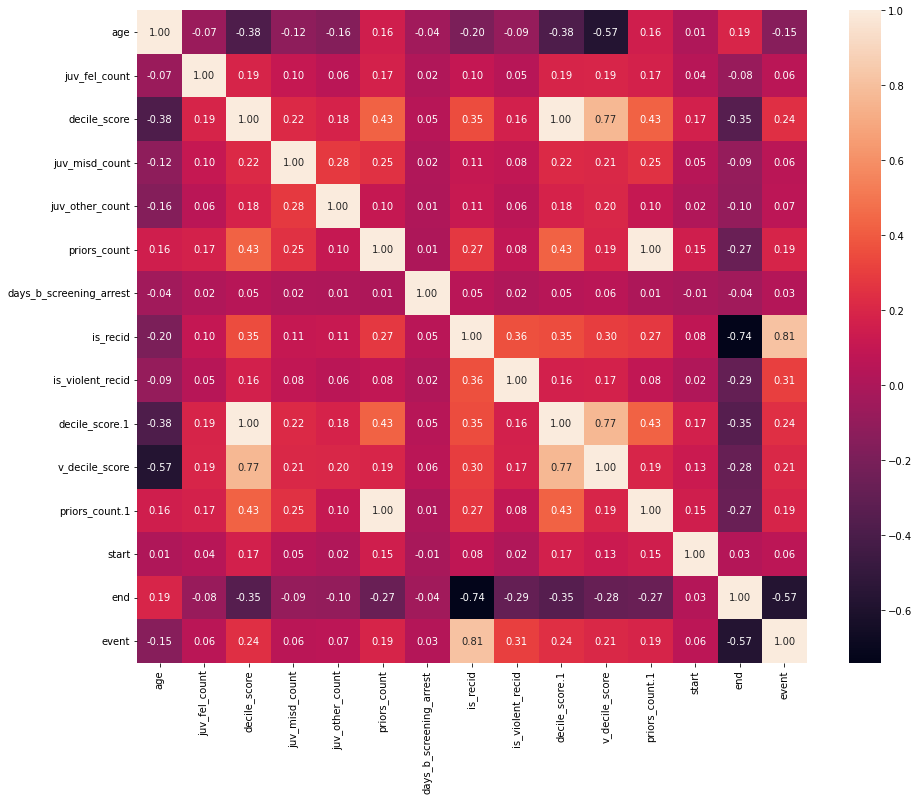

In [38]:
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [39]:
X.apply(lambda x: x.nunique())

first                      2430
last                       3427
compas_screening_date       684
age                          63
age_cat                       3
race                          2
juv_fel_count                10
decile_score                 10
juv_misd_count               10
juv_other_count               9
priors_count                 37
days_b_screening_arrest     381
c_jail_in                  5915
c_jail_out                 5893
c_offense_date              890
c_days_from_compas          455
c_charge_degree               2
c_charge_desc               410
is_recid                      2
is_violent_recid              2
type_of_assessment            1
decile_score.1               10
score_text                    3
screening_date              684
v_type_of_assessment          1
v_decile_score               10
v_score_text                  3
v_screening_date            684
in_custody                 1131
out_custody                1150
priors_count.1               37
start   

In [40]:
enc = OneHotEncoder(handle_unknown='ignore')
X_new = enc.fit(X)
X_new = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.3,random_state=1234)

### **Baseline Model**

In [41]:
forest = RandomForestClassifier(random_state=1234).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X = cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9658536585365853
[[942  61]
 [  2 840]]
0.006187746733628763


In [42]:
categorical_features = ['first','last','age_cat','race','c_charge_degree','c_charge_desc','type_of_assessment',
                       'score_text','v_type_of_assessment','v_score_text']

In [44]:
selected_column= X[categorical_features]
categorical_df = selected_column.copy()

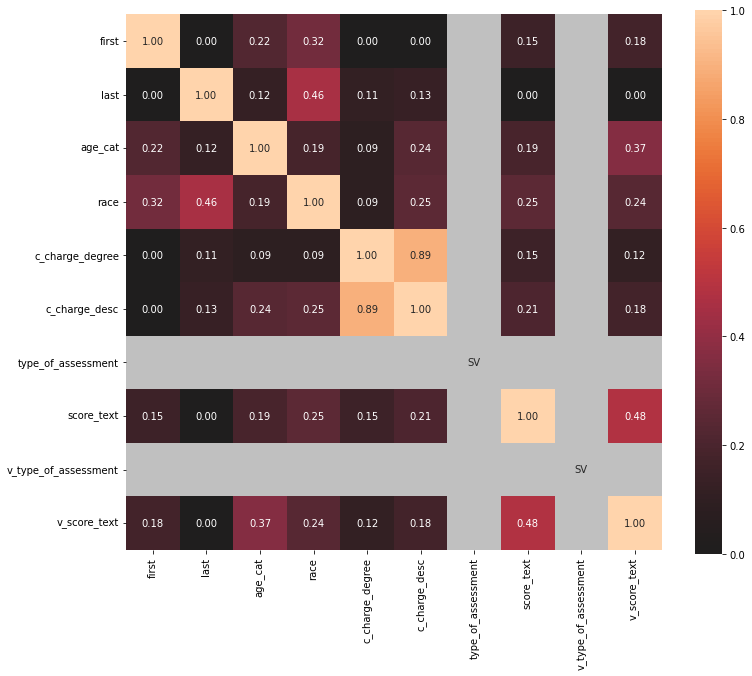

In [45]:
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(12,10))

#### Local Massing - Algorithm 1 (A6)

# Local Massaging Algorithm 
It is a pre-processing method, means that we handle the dataset first before running our model, and the purpose of local massaging is to relabel the data points close to decision boundary. 

The logic is simple. Assume that we have a group of people, divide to two groups by female and male, and our response binary variable be graduated or not for example. In order to debias the dataset, we are trying to make P(graduated|female) = P(graduated|male) = P(graduated). Just before we do this, be aware that we have lots of variables will influence a person's acedemic path, thus we need to find those who are highly correlated to gender, and take them out to avoid further bias and focus on rest of indifference variables. Finally, try to modify response variable to achieve our objective probability equality.


Reference: https://www.researchgate.net/publication/220766841_Handling_Conditional_Discrimination

In [46]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize # for loss func minimization
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


#################### A6 ####################

def partition(X,e):
    e_list = list(e.keys())
    X_i = []
    for i in range(len(e_list)):
        X[e_list[i]] = e[e_list[i]]
        X_i.append(X)
    return X_i

def ceildiv(a, b):
    return -(a // -b)

def delta(item, y_pred, y_prob, G_i = 12):
    
    item_copy = item.copy()
    item_copy['label'] = y_pred
    af = item_copy[item_copy.race=='African-American']
    ca = item_copy[item_copy.race =='Caucasian']
    rate_af = round(af[af['label']==1].shape[0]/af.shape[0],2)
    rate_ca = round(ca[ca['label']==1].shape[0]/ca.shape[0],2)
    p_star = (rate_af+rate_ca)/2
    threshold = np.abs(rate_af-p_star)
    
    test_df = pd.DataFrame(y_prob,columns=['No','Yes'])
    test_df.set_index(item.index,inplace=True)
    test_df['race']=item['race']
    test_df['label'] = y_pred
    temp = test_df[(np.abs(test_df.Yes - test_df.No)<=G_i*threshold)]
#     print(temp.shape[0],threshold)
    for i in range(temp.shape[0]):
        if temp.race.iloc[i] == 'African-American' and temp.Yes.iloc[i] > temp.No.iloc[i]:
            temp.label.iloc[i] = 0
        elif temp.race.iloc[i] == 'Caucasian' and temp.Yes.iloc[i] < temp.No.iloc[i]:
            temp.label.iloc[i] = 1
    
    item_copy['label'].loc[temp.index] = temp.label
    
    return item_copy



def local_massaging(X,s,e,y):
    X['race'] = s
    X_i_list =partition(X,e)
    df_list = []
    pd_list = []
    for item in X_i_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        X_new = enc.fit(item)
        X_new = enc.transform(item)
        X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=5)
        forest = RandomForestClassifier(random_state=44).fit(X_train, y_train) 
        y_pred = forest.predict(X_new)
        y_prob = forest.predict_proba(X_new)
        temp_df = delta(item,y_pred,y_prob)
        pd_list.append(temp_df)
        df_list.append(temp_df[['label']])
    
    # Here we take vote 
    
    result = pd.concat(df_list,axis = 1)
    result.loc[result.sum(axis=1)<=2,'new_label'] = 0
    result.loc[result.sum(axis=1)>=3,'new_label'] = 1
    X['new_label'] = result.new_label
    return X



### By creating a correlation table, we are able to find proper ei that highly related to race. I set the threshold be 0.25, thus we will have "first", 'last','c_charge_desc', 'score_text'

In [47]:
e_list = ['first', 'last','c_charge_desc', 'score_text']
exclude_e_s = ['v_score_text',
 'compas_screening_date',
 'age',
 'age_cat',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_offense_date',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'type_of_assessment',
 'decile_score.1',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event']
e = X[e_list]
new_X = X[exclude_e_s]
s = X[['race']]

In [48]:
New_X = local_massaging(new_X,s,e,y)

In [49]:
af = New_X[New_X.race=='African-American']

ca = New_X[New_X.race =='Caucasian']
rate_af_cu = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca_cu = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [50]:
print(f'The rate of current Recidivism for African-American is {rate_af_cu}')
print(f'The rate of current Recidivism for Caucasian is {rate_ca_cu}')

The rate of current Recidivism for African-American is 0.45
The rate of current Recidivism for Caucasian is 0.44


In [61]:
print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.39


In [60]:
print(accuracy_score(y_test, y_pred_test))
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9658536585365853
0.006187746733628763


#### Local Preferential Sampling - Algorithm 2 (A6)

In [56]:
def ceildiv(a, b):
    return -(a // -b)

def local_preferential_sampling(X,s,e,y):
    
    X = pd.concat([X, s],axis=1)
    cols = list(X.columns)
    X_i_list = []
    e_list = e.columns
    for i in range(2, len(e_list)+1):
        iter_ = iter_ = itertools.combinations(e_list,i)
        X_i_list.extend(list(iter_))
    
    feature_list = []
    for j in X_i_list:
        comb_j = pd.concat([X, e[[x for x in j]]], axis=1)
        feature_list.append(comb_j)
    
    est_list = []
    
    for part in feature_list:
        onehot_feats = OneHotEncoder(handle_unknown='ignore')
        X_ = onehot_feats.fit(part)
        X_ = onehot_feats.transform(part)
        estimator = RandomForestClassifier(random_state=1234).fit(X_, y)
        y_pred = estimator.predict(X_)
        y_prob = estimator.predict_proba(X_)
        
        part_copy = part.copy()
        part_copy['label'] = y_pred
        af = part_copy[part_copy['race'] == 'African-American']
        ca = part_copy[part_copy['race'] == 'Caucasian']
        pct_avg = (np.mean(af['label']) + np.mean(ca['label'])) / 2
        threshold = np.abs(np.mean(af['label']) - pct_avg)
        
        pred_df = pd.DataFrame(y_prob, columns=['No','Yes'])
        pred_df['race'] = part_copy['race']
        pred_df['label'] = y_pred
        pred_df['thre'] = (np.abs(pred_df.Yes - pred_df.No) <= 5*threshold)
        temp = pred_df[pred_df['thre'] == 1]
        temp_dic = temp[['race','label']].value_counts().to_dict()
    
        aa_0,aa_1,ca_0,ca_1 = 0,0,0,0
        for key, value in zip(temp_dic.keys(),temp_dic.values()):
            if key == ('African-American', 1):
                aa_1 = ceildiv(value,2)
            if key == ('African-American', 0):
                aa_0 = ceildiv(value,2)       
            if key == ('Caucasian', 1):
                ca_1 = ceildiv(value,2)        
            if key == ('Caucasian', 0):
                ca_0 = ceildiv(value,2)
        
        if aa_1>aa_0:
            aa_replace = aa_0
        else:
            aa_replace = aa_1

        if ca_1>ca_0:
            ca_replace = ca_0
        else:
            ca_replace = ca_1

        count_aa = 0
        count_ca = 0
        
        while(count_aa<aa_replace):
            for idx in list(temp.index):
                if temp.race.loc[idx] == 'African-American' and temp.label.loc[idx] ==1:
                    temp.label.loc[idx] = 0
                    count_aa +=1
            
        while(count_ca<ca_replace):
            for idx in list(temp.index):
                if temp.race.loc[idx] == 'Caucasian' and temp.label.loc[idx] ==0:
                    temp.label.loc[idx] = 1
                    count_ca +=1
        
        pred_df['label'].loc[temp.index] = temp.label
        
        est_list.append(pred_df[['label']])
    
    res = pd.concat(est_list, axis=1)
    res['row_sums'] = res.apply(lambda x: x.sum(), axis=1)
    X['new_label'] = np.where(res['row_sums'] <= len(X_i_list)/2, 0, 1)
        
    return X

In [62]:
e_list = ['first', 'last','c_charge_desc', 'score_text']
exclude_e_s = ['v_score_text',
 'compas_screening_date',
 'age',
 'age_cat',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_offense_date',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'type_of_assessment',
 'decile_score.1',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event']
e = X[e_list]
new_X = X[exclude_e_s]
s = X[['race']]

In [63]:
# X_New = ut.local_preferential_sampling(new_X,s,e,y)
X_New = local_preferential_sampling(new_X,s,e,y)
af = X_New[X_New.race=='African-American']
ca = X_New[X_New.race =='Caucasian']
rate_af = round(np.mean(af['new_label']==1),2)
rate_ca = round(np.mean(ca['new_label']==1),2)

In [64]:
print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')
print(f'The Corrected Recidivism rate should be {(rate_af+rate_ca)/2:,} ')

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.39
The Corrected Recidivism rate should be 0.45 


In [66]:
y_New = X_New.new_label
X_New_copy = X_New.copy()
X_New_copy.drop(['new_label'],axis=1,inplace=True)
X_new = enc.fit(X_New_copy)
X_new = enc.transform(X_New_copy)
X_train, X_test, y_train, y_test = train_test_split(X_new,y_New,test_size=0.3,random_state=1234)
forest = RandomForestClassifier(random_state=1234).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)

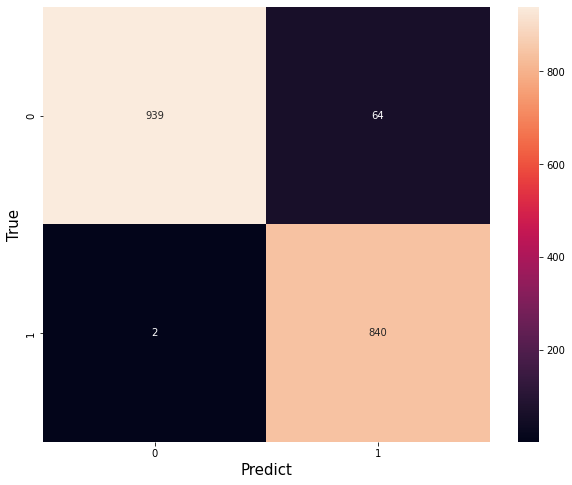

In [67]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.xlabel('Predict',size=15)
plt.ylabel('True',size=15)
plt.show()

In [68]:
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X_New.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9642276422764228
[[939  64]
 [  2 840]]
0.008863928714003433
